# Spam detection

#### Kristjan Lõhmus

##### University of Tartu

## 1. Dataset preparation

In [1]:
import pandas as pd
import gzip
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras

### 1.1 Label processing

#### 1.1.2. WEBSPAM-UK2007

In [2]:
hostnames_2007 = pd.read_csv('data/2007/WEBSPAM-UK2007-hostnames.txt', header=None, names=['hostname'], sep='\s+')
nodes_train_2007 = pd.read_csv('data/2007/WEBSPAM-UK2007-SET1-labels.txt',names=['label', 'spamicity', 'assessments'],index_col=0, header=None, sep='\s+')
nodes_train_2007['source'] = 'train'
nodes_test_2007 = pd.read_csv('data/2007/WEBSPAM-UK2007-SET2-labels.txt',names=['label', 'spamicity', 'assessments'],index_col=0, header=None, sep='\s+')
nodes_test_2007['source'] = 'test'
nodes_2007 = pd.concat([nodes_train_2007, nodes_test_2007], axis=0)
nodes_2007 = nodes_2007[nodes_2007['label'] != 'undecided']
nodes_2007['y_true'] = nodes_2007['label'].replace({'nonspam': 0, 'spam': 1})
nodes_2007.drop(columns=['label', 'assessments'], inplace=True)
nodes_2007 = pd.merge(hostnames_2007, nodes_2007, left_index=True, right_index=True, how='right')
nodes_2007

,hostname,spamicity,source,y_true
4,109belfast.boys-brigade.org.uk,0.000000,train,0
5,10bristol.boys-brigade.org.uk,0.000000,train,0
8,10enfield.boys-brigade.org.uk,0.000000,train,0
61,1inverurie.boys-brigade.org.uk,0.000000,train,0
62,1kempston.boys-brigade.org.uk,0.000000,train,0
...,...,...,...,...
114401,www2.netdoctor.co.uk,0.000000,test,0
114442,www3.shropshire-cc.gov.uk,0.000000,test,0
114469,xclusiveproperties.co.uk,1.000000,test,1
114487,yellowcello.mysite.wanadoo-members.co.uk,0.000000,test,0


## 1.2 Features for predictions

#### 1.2.2 WEBSPAM-UK2007

In [3]:
#feature set 1

direct_features_df_2007 = pd.read_csv('data/2007/uk-2007-05.obvious_features.csv.gz', index_col=0)
direct_features_df_2007 = pd.merge(left=nodes_2007, right=direct_features_df_2007.drop(columns=['hostname']), how='left', left_index=True, right_index=True)
direct_features_df_2007

,hostname,spamicity,source,y_true,number_of_pages,length_of_hostname
4,109belfast.boys-brigade.org.uk,0.000000,train,0,1,30
5,10bristol.boys-brigade.org.uk,0.000000,train,0,20,29
8,10enfield.boys-brigade.org.uk,0.000000,train,0,9,29
61,1inverurie.boys-brigade.org.uk,0.000000,train,0,14,30
62,1kempston.boys-brigade.org.uk,0.000000,train,0,42,29
...,...,...,...,...,...,...
114401,www2.netdoctor.co.uk,0.000000,test,0,12587,20
114442,www3.shropshire-cc.gov.uk,0.000000,test,0,2034,25
114469,xclusiveproperties.co.uk,1.000000,test,1,20,24
114487,yellowcello.mysite.wanadoo-members.co.uk,0.000000,test,0,49,40


In [4]:
direct_features_df_2007['source']

4         train
5         train
8         train
61        train
62        train
          ...  
114401     test
114442     test
114469     test
114487     test
114507     test
Name: source, Length: 6053, dtype: object

In [5]:
# scale features
scaler = MinMaxScaler()
direct_features_df_2007_X = pd.DataFrame(scaler.fit_transform(direct_features_df_2007.drop(columns=['hostname', 'spamicity', 'source', 'y_true'])))
direct_features_df_2007_X = pd.concat([direct_features_df_2007['source'].reset_index(drop=True), direct_features_df_2007_X.reset_index(drop=True)], axis=1)
direct_features_df_2007_X

,source,0,1
0,train,0.000000,0.291667
1,train,0.000380,0.277778
2,train,0.000160,0.277778
3,train,0.000260,0.291667
4,train,0.000820,0.277778
...,...,...,...
6048,test,0.251730,0.152778
6049,test,0.040662,0.222222
6050,test,0.000380,0.208333
6051,test,0.000960,0.430556


In [6]:
#feature set 2a
link_based_features_df_2007 = pd.read_csv('data/2007/uk-2007-05.link_based_features.csv.gz', index_col=0)
link_based_features_df_2007 = pd.merge(left=nodes_2007, right=link_based_features_df_2007.drop(columns=['hostname']), how='left', left_index=True, right_index=True)
link_based_features_df_2007

,hostname,spamicity,source,y_true,eq_hp_mp,assortativity_hp,assortativity_mp,avgin_of_out_hp,avgin_of_out_mp,avgout_of_in_hp,...,truncatedpagerank_1_hp,truncatedpagerank_1_mp,truncatedpagerank_2_hp,truncatedpagerank_2_mp,truncatedpagerank_3_hp,truncatedpagerank_3_mp,truncatedpagerank_4_hp,truncatedpagerank_4_mp,trustrank_hp,trustrank_mp
4,109belfast.boys-brigade.org.uk,0.000000,train,0,1,0.001186,0.001186,20093.000000,20093.000000,239.000000,...,8.475692e-10,8.475692e-10,8.820278e-10,8.820278e-10,8.986675e-10,8.986675e-10,9.174294e-10,9.174294e-10,5.938985e-10,5.938985e-10
5,10bristol.boys-brigade.org.uk,0.000000,train,0,1,0.885731,0.885731,16.909090,16.909090,42.393940,...,1.388360e-08,1.388360e-08,1.301128e-08,1.301128e-08,1.211512e-08,1.211512e-08,1.130883e-08,1.130883e-08,3.651300e-09,3.651300e-09
8,10enfield.boys-brigade.org.uk,0.000000,train,0,1,0.074253,0.074253,1.500000,1.500000,61.777779,...,8.619567e-08,8.619567e-08,8.831332e-08,8.831332e-08,9.565486e-08,9.565486e-08,1.030738e-07,1.030738e-07,6.231077e-08,6.231077e-08
61,1inverurie.boys-brigade.org.uk,0.000000,train,0,0,0.033302,1.448276,13.000000,10.285714,196.399994,...,2.005446e-09,2.571986e-08,2.080073e-09,2.648100e-08,2.121224e-09,2.724231e-08,2.159312e-09,2.795396e-08,8.125821e-10,5.865546e-09
62,1kempston.boys-brigade.org.uk,0.000000,train,0,0,0.807415,1.469636,1.000000,18.181818,53.680851,...,6.650522e-09,2.269689e-08,5.403783e-09,2.289603e-08,4.925066e-09,2.285000e-08,4.099807e-09,2.285477e-08,2.646462e-09,5.020827e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114401,www2.netdoctor.co.uk,0.000000,test,0,0,98.032822,40.790058,248.452377,9964.170898,39.802406,...,1.689350e-07,1.043173e-06,1.105436e-07,8.908141e-07,8.095669e-08,8.790846e-07,6.882792e-08,8.824565e-07,7.698599e-08,2.405377e-07
114442,www3.shropshire-cc.gov.uk,0.000000,test,0,0,0.095343,2.087370,537.333313,3081.714355,39.062500,...,1.104646e-08,5.525479e-07,1.209729e-08,5.579683e-07,1.221414e-08,5.630115e-07,1.240599e-08,5.688678e-07,3.170236e-09,1.538194e-07
114469,xclusiveproperties.co.uk,1.000000,test,1,1,0.676611,0.676611,15.833333,15.833333,17.150000,...,3.733386e-08,3.733386e-08,3.856891e-08,3.856891e-08,3.941532e-08,3.941532e-08,4.013246e-08,4.013246e-08,7.934806e-09,7.934806e-09
114487,yellowcello.mysite.wanadoo-members.co.uk,0.000000,test,0,0,0.029131,21.818182,981.500000,1.000000,23.833334,...,2.710049e-09,1.263861e-07,2.426414e-09,1.421390e-07,2.209043e-09,1.277062e-07,2.018897e-09,1.423364e-07,1.064249e-09,2.991848e-08


In [7]:
scaler = MinMaxScaler()
link_based_features_df_2007_X = pd.DataFrame(scaler.fit_transform(link_based_features_df_2007.drop(columns=['hostname', 'spamicity', 'source', 'y_true'])))
link_based_features_df_2007_X = pd.concat([link_based_features_df_2007['source'].reset_index(drop=True), link_based_features_df_2007_X.reset_index(drop=True)], axis=1)
link_based_features_df_2007_X

,source,0,1,2,3,4,5,6,7,8,...,31,32,33,34,35,36,37,38,39,40
0,train,1.0,2.536436e-07,1.687767e-07,0.075741,0.041199,0.171203,0.171203,0.000019,0.000019,...,0.000005,0.000005,0.000006,0.000006,0.000006,0.000006,0.000006,0.000006,5.781804e-07,1.864068e-07
1,train,1.0,1.932651e-04,1.296528e-04,0.000064,0.000035,0.030368,0.030368,0.000155,0.000155,...,0.000126,0.000126,0.000118,0.000118,0.000110,0.000110,0.000101,0.000101,1.219569e-05,3.931922e-06
2,train,1.0,1.619720e-05,1.086470e-05,0.000006,0.000003,0.044253,0.044253,0.000084,0.000084,...,0.000800,0.000800,0.000819,0.000819,0.000881,0.000881,0.000933,0.000933,2.350899e-04,7.579358e-05
3,train,0.0,7.261667e-06,2.120008e-04,0.000049,0.000021,0.140688,0.005069,0.000023,0.000061,...,0.000016,0.000237,0.000017,0.000244,0.000017,0.000249,0.000017,0.000252,1.409134e-06,6.644517e-06
4,train,0.0,1.761762e-04,2.151275e-04,0.000004,0.000037,0.038453,0.008289,0.000220,0.000098,...,0.000059,0.000209,0.000048,0.000210,0.000043,0.000209,0.000035,0.000205,8.377508e-06,5.609682e-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048,test,0.0,2.139116e-02,5.971040e-03,0.000937,0.020431,0.028512,0.037824,0.024548,0.038631,...,0.001571,0.009713,0.001025,0.008280,0.000745,0.008115,0.000623,0.008008,2.908528e-04,2.941331e-04
6049,test,0.0,2.079910e-05,3.055545e-04,0.002025,0.006319,0.027982,0.381834,0.000075,0.010423,...,0.000100,0.005143,0.000110,0.005185,0.000110,0.005197,0.000110,0.005161,1.036775e-05,1.878976e-04
6050,test,1.0,1.476342e-04,9.904077e-05,0.000060,0.000032,0.012285,0.012285,0.000094,0.000094,...,0.000345,0.000345,0.000356,0.000356,0.000362,0.000362,0.000362,0.000362,2.847216e-05,9.179494e-06
6051,test,0.0,6.351349e-06,3.193846e-03,0.003700,0.000002,0.017073,0.000866,0.000028,0.000112,...,0.000022,0.001174,0.000020,0.001319,0.000018,0.001177,0.000016,0.001290,2.365416e-06,3.611092e-05


In [8]:
#feature set 2b
link_based_transformed_features_df_2007 = pd.read_csv('data/2007/uk-2007-05.link_based_features_transformed.csv.gz', index_col=0)
link_based_transformed_features_df_2007 = pd.merge(left=nodes_2007, right=link_based_transformed_features_df_2007, how='left', left_index=True, right_index=True)
link_based_transformed_features_df_2007

,hostname,spamicity,source,y_true,L_indegree_hp,L_indegree_mp,L_outdegree_hp,L_outdegree_mp,reciprocity_hp,reciprocity_mp,...,log_OP_min_OP_truncatedpagerank_2_hp_div_truncatedpagerank_1_hp_truncatedpagerank_3_hp_div_truncatedpagerank_2_hp_truncatedpagerank_4_hp_div_truncatedpagerank_3_hp_CP__CP_,log_OP_min_OP_truncatedpagerank_2_mp_div_truncatedpagerank_1_mp_truncatedpagerank_3_mp_div_truncatedpagerank_2_mp_truncatedpagerank_4_mp_div_truncatedpagerank_3_mp_CP__CP_,log_OP_max_OP_truncatedpagerank_2_hp_div_truncatedpagerank_1_hp_truncatedpagerank_3_hp_div_truncatedpagerank_2_hp_truncatedpagerank_4_hp_div_truncatedpagerank_3_hp_CP__CP_,log_OP_max_OP_truncatedpagerank_2_mp_div_truncatedpagerank_1_mp_truncatedpagerank_3_mp_div_truncatedpagerank_2_mp_truncatedpagerank_4_mp_div_truncatedpagerank_3_mp_CP__CP_,log_OP_avg_OP_truncatedpagerank_2_hp_div_truncatedpagerank_1_hp_truncatedpagerank_3_hp_div_truncatedpagerank_2_hp_truncatedpagerank_4_hp_div_truncatedpagerank_3_hp_CP__CP_,log_OP_avg_OP_truncatedpagerank_2_mp_div_truncatedpagerank_1_mp_truncatedpagerank_3_mp_div_truncatedpagerank_2_mp_truncatedpagerank_4_mp_div_truncatedpagerank_3_mp_CP__CP_,truncatedpagerank_1_mp_div_truncatedpagerank_1_hp,truncatedpagerank_2_mp_div_truncatedpagerank_2_hp,truncatedpagerank_3_mp_div_truncatedpagerank_3_hp,truncatedpagerank_4_mp_div_truncatedpagerank_4_hp
4,109belfast.boys-brigade.org.uk,0.000000,train,0,1.386294,1.386294,0.000000,0.000000,0.000000,0.000000,...,0.018689,0.018689,0.039851,0.039851,0.026447,0.026447,1.000000,1.000000,1.000000,1.000000
5,10bristol.boys-brigade.org.uk,0.000000,train,0,3.496508,3.496508,2.397895,2.397895,0.909091,0.909091,...,-0.071362,-0.071362,-0.064891,-0.064891,-0.068371,-0.068371,1.000000,1.000000,1.000000,1.000000
8,10enfield.boys-brigade.org.uk,0.000000,train,0,2.890372,2.890372,0.693147,0.693147,0.000000,0.000000,...,0.024271,0.024271,0.079856,0.079856,0.059921,0.059921,1.000000,1.000000,1.000000,1.000000
61,1inverurie.boys-brigade.org.uk,0.000000,train,0,1.609438,2.564949,0.000000,1.791759,0.000000,1.000000,...,0.017796,0.025788,0.036537,0.029164,0.024677,0.027766,12.825006,12.730804,12.842731,12.945773
62,1kempston.boys-brigade.org.uk,0.000000,train,0,3.850148,3.044522,0.693147,2.302585,0.500000,1.000000,...,-0.207596,-0.002012,-0.092762,0.008736,-0.160019,0.002321,3.412798,4.237037,4.639533,5.574597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114401,www2.netdoctor.co.uk,0.000000,test,0,8.563695,9.017120,3.713572,4.709530,0.738095,0.027027,...,-0.424104,-0.157886,-0.162305,0.003828,-0.293526,-0.053184,6.174995,8.058486,10.858703,12.821200
114442,www3.shropshire-cc.gov.uk,0.000000,test,0,2.772589,7.707063,2.708050,2.564949,0.200000,0.928571,...,0.009612,0.008998,0.090872,0.010348,0.039379,0.009703,50.020374,46.123400,46.095069,45.854283
114469,xclusiveproperties.co.uk,1.000000,test,1,2.995732,2.995732,1.609438,1.609438,1.000000,1.000000,...,0.018031,0.018031,0.032546,0.032546,0.024114,0.024114,1.000000,1.000000,1.000000,1.000000
114487,yellowcello.mysite.wanadoo-members.co.uk,0.000000,test,0,1.791759,3.178054,0.693147,3.178054,0.000000,0.958333,...,-0.110552,-0.107073,-0.090008,0.117464,-0.098099,0.044866,46.636108,58.579837,57.810657,70.502022


In [9]:
scaler = MinMaxScaler()
link_based_transformed_features_df_2007_X = pd.DataFrame(scaler.fit_transform(link_based_transformed_features_df_2007.drop(columns=['hostname', 'spamicity', 'source', 'y_true'])))
link_based_transformed_features_df_2007_X = pd.concat([link_based_transformed_features_df_2007['source'].reset_index(drop=True), link_based_transformed_features_df_2007_X.reset_index(drop=True)], axis=1)
link_based_transformed_features_df_2007_X

,source,0,1,2,3,4,5,6,7,8,...,128,129,130,131,132,133,134,135,136,137
0,train,0.825207,0.825207,0.876132,0.876132,0.000000,0.000000,0.205836,0.187417,0.958705,...,0.867642,0.871916,0.746075,0.728908,0.793702,0.799003,0.000012,0.000009,0.000010,0.000010
1,train,0.859094,0.859094,0.918149,0.918149,0.909091,0.909091,0.552252,0.532778,0.845400,...,0.772138,0.788175,0.527734,0.495805,0.636218,0.652571,0.000012,0.000009,0.000010,0.000010
2,train,0.849361,0.849361,0.888278,0.888278,0.000000,0.000000,0.422456,0.403377,0.806635,...,0.873562,0.877106,0.829466,0.817937,0.849299,0.850699,0.000012,0.000009,0.000010,0.000010
3,train,0.828790,0.844135,0.876132,0.907528,0.000000,1.000000,0.380472,0.558445,0.841193,...,0.866695,0.878517,0.739166,0.705124,0.790762,0.801041,0.000228,0.000187,0.000174,0.000165
4,train,0.864773,0.851836,0.888278,0.916479,0.500000,1.000000,0.547405,0.559209,0.800146,...,0.627655,0.852665,0.469637,0.659661,0.484000,0.761745,0.000056,0.000058,0.000060,0.000069
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6048,test,0.940468,0.947749,0.941204,0.958655,0.738095,0.027027,0.798689,0.732692,0.888407,...,0.398037,0.707715,0.324670,0.648739,0.262257,0.676025,0.000106,0.000116,0.000147,0.000163
6049,test,0.847469,0.926711,0.923584,0.921077,0.200000,0.928571,0.435546,0.577526,0.900751,...,0.858016,0.862904,0.852431,0.663249,0.815182,0.773145,0.000907,0.000694,0.000636,0.000592
6050,test,0.851052,0.851052,0.904334,0.904334,1.000000,1.000000,0.538150,0.518719,0.844348,...,0.866944,0.871304,0.730847,0.712650,0.789827,0.795401,0.000012,0.000009,0.000010,0.000010
6051,test,0.831718,0.853980,0.888278,0.931820,0.000000,0.958333,0.373464,0.700031,0.910392,...,0.730575,0.754968,0.475377,0.901633,0.586844,0.827448,0.000845,0.000883,0.000798,0.000912


In [10]:
# feature set 3a
content_based_df_2007 = pd.read_csv('data/2007/uk-2007-05.content_based_features.csv.gz', index_col=0)
content_based_df_2007 = pd.merge(left=nodes_2007, right=content_based_df_2007.drop(columns=['hostname']), how='left', left_index=True, right_index=True)
content_based_df_2007.dropna(axis=0, how='any', inplace=True)
content_based_df_2007

,hostname,spamicity,source,y_true,HST_1,HST_2,HST_3,HST_4,HST_5,HST_6,...,STD_87,STD_88,STD_89,STD_90,STD_91,STD_92,STD_93,STD_94,STD_95,STD_96
4,109belfast.boys-brigade.org.uk,0.000000,train,0,62.0,8.0,4.967742,0.016129,0.033315,1.761905,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,10bristol.boys-brigade.org.uk,0.000000,train,0,94.0,1.0,4.989362,0.085106,0.015302,2.069853,...,0.002106,0.004367,0.002882,0.004603,0.000223,0.001414,0.001416,0.000567,0.730257,0.635154
8,10enfield.boys-brigade.org.uk,0.000000,train,0,16.0,5.0,4.875000,0.000000,0.032653,1.119048,...,0.000322,0.000776,0.003927,0.005491,0.009611,0.002665,0.002668,0.003952,1.295359,1.075073
61,1inverurie.boys-brigade.org.uk,0.000000,train,0,13.0,2.0,4.769231,0.230769,0.015532,1.071429,...,0.000182,0.001685,0.007376,0.008834,0.000221,0.000213,0.000120,0.000122,0.835484,0.610877
62,1kempston.boys-brigade.org.uk,0.000000,train,0,12.0,1.0,4.583333,0.000000,0.017778,1.030769,...,0.000184,0.000742,0.002855,0.002916,0.003115,0.004348,0.002474,0.000999,0.796034,0.781804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114332,www.zoo.co.uk,0.000000,test,0,23.0,3.0,4.260870,0.043478,0.071875,1.315217,...,0.001920,0.001846,0.002857,0.004733,0.470135,0.225870,0.126177,0.077075,3.250683,2.711477
114401,www2.netdoctor.co.uk,0.000000,test,0,490.0,8.0,5.071429,0.051020,0.009629,2.267530,...,0.000040,0.000241,0.000366,0.000541,0.007971,0.012601,0.004325,0.001761,0.090197,0.087969
114442,www3.shropshire-cc.gov.uk,0.000000,test,0,669.0,3.0,4.840060,0.028401,0.070244,2.177815,...,0.000110,0.000359,0.000699,0.000694,0.036982,0.020839,0.016663,0.009359,0.707329,0.584035
114469,xclusiveproperties.co.uk,1.000000,test,1,222.0,4.0,4.599099,0.162162,0.031512,2.231598,...,0.000045,0.000125,0.000354,0.000666,0.000319,0.000174,0.000887,0.000372,0.171390,0.070065


In [11]:
scaler = MinMaxScaler()
content_based_df_2007_X = pd.DataFrame(scaler.fit_transform(content_based_df_2007.drop(columns=['hostname', 'spamicity', 'source', 'y_true'])))
content_based_df_2007_X = pd.concat([content_based_df_2007['source'].reset_index(drop=True), content_based_df_2007_X.reset_index(drop=True)], axis=1)
content_based_df_2007_X

,source,0,1,2,3,4,5,6,7,8,...,86,87,88,89,90,91,92,93,94,95
0,train,0.000471,0.050633,0.305211,0.000175,0.200510,0.057217,0.112903,0.129032,0.177419,...,2.312965e-18,2.359224e-16,2.359224e-16,7.494005e-16,0.000000,9.623746e-21,2.827519e-21,2.495846e-21,1.721930e-15,2.350640e-15
1,train,0.000718,0.006329,0.306874,0.000925,0.091731,0.069551,0.148936,0.244681,0.329787,...,1.123321e-02,1.746900e-02,1.152716e-02,1.841381e-02,0.000003,4.366109e-05,7.387450e-05,2.610563e-05,6.155493e-02,7.308643e-02
2,train,0.000116,0.031646,0.298077,0.000000,0.196510,0.031469,0.062500,0.187500,0.187500,...,1.715985e-03,3.102426e-03,1.570719e-02,2.196522e-02,0.000148,8.228704e-05,1.391818e-04,1.819445e-04,1.091887e-01,1.237075e-01
3,train,0.000093,0.012658,0.289941,0.002508,0.093118,0.029562,0.230769,0.307692,0.384615,...,9.691715e-04,6.739034e-03,2.950524e-02,3.533701e-02,0.000003,6.584401e-06,6.277119e-06,5.611506e-06,7.042476e-02,7.029297e-02
4,train,0.000085,0.006329,0.275641,0.000000,0.106681,0.027934,0.083333,0.166667,0.166667,...,9.805757e-04,2.966903e-03,1.141940e-02,1.166293e-02,0.000048,1.342381e-04,1.290235e-04,4.597885e-05,6.709949e-02,8.996132e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792,test,0.000170,0.018987,0.250836,0.000473,0.433364,0.039326,0.130435,0.130435,0.304348,...,1.023858e-02,7.383291e-03,1.142876e-02,1.893025e-02,0.007224,6.973558e-03,6.581217e-03,3.548565e-03,2.740071e-01,3.120067e-01
5793,test,0.003773,0.050633,0.313187,0.000555,0.057474,0.077468,0.157143,0.183673,0.242857,...,2.154157e-04,9.620051e-04,1.464595e-03,2.164355e-03,0.000122,3.890395e-04,2.256065e-04,8.105866e-05,7.602891e-03,1.012249e-02
5794,test,0.005154,0.018987,0.295389,0.000309,0.423513,0.073875,0.071749,0.113602,0.158445,...,5.882724e-04,1.437648e-03,2.794531e-03,2.775276e-03,0.000568,6.433753e-04,8.690974e-04,4.309092e-04,5.962227e-02,6.720431e-02
5795,test,0.001705,0.025316,0.276854,0.001763,0.189618,0.076029,0.229730,0.261261,0.328829,...,2.413347e-04,5.003397e-04,1.417959e-03,2.662959e-03,0.000005,5.362467e-06,4.623906e-05,1.712467e-05,1.444682e-02,8.062260e-03


In [12]:
datasets = [   
    { 
        'key': 'direct_features_2007',
        'x_train': direct_features_df_2007_X[direct_features_df_2007_X['source']=='train'].drop(columns=['source']),
        'y_train': direct_features_df_2007[direct_features_df_2007['source']=='train']['y_true'],
        'x_test': direct_features_df_2007_X[direct_features_df_2007_X['source']=='test'].drop(columns=['source']),
        'y_test': direct_features_df_2007[direct_features_df_2007['source']=='test']['y_true']
    },
    {
        'key': 'link_based_2007',
        'x_train': link_based_features_df_2007_X[link_based_features_df_2007_X['source']=='train'].drop(columns=['source']),
        'y_train': link_based_features_df_2007[link_based_features_df_2007['source']=='train']['y_true'],
        'x_test': link_based_features_df_2007_X[link_based_features_df_2007_X['source']=='test'].drop(columns=['source']),
        'y_test': link_based_features_df_2007[link_based_features_df_2007['source']=='test']['y_true']
    },    
    {
        'key': 'link_based_transformed_2007',
        'x_train': link_based_transformed_features_df_2007_X[link_based_transformed_features_df_2007_X['source']=='train'].drop(columns=['source']),
        'y_train': link_based_transformed_features_df_2007[link_based_transformed_features_df_2007['source']=='train']['y_true'],
        'x_test': link_based_transformed_features_df_2007_X[link_based_transformed_features_df_2007_X['source']=='test'].drop(columns=['source']),
        'y_test': link_based_transformed_features_df_2007[link_based_transformed_features_df_2007['source']=='test']['y_true']
    },
    {
        'key': 'content_based_2007',
        'x_train': content_based_df_2007_X[content_based_df_2007_X['source']=='train'].drop(columns=['source']),
        'y_train': content_based_df_2007[content_based_df_2007['source']=='train']['y_true'],
        'x_test': content_based_df_2007_X[content_based_df_2007_X['source']=='test'].drop(columns=['source']),
        'y_test': content_based_df_2007[content_based_df_2007['source']=='test']['y_true']
    }
]

## 3. Predictions

### 3.1. Machine learning models

In [13]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
import warnings
warnings.filterwarnings('ignore')

results = []

#### 3.1.1. SVM

In [14]:
for dataset in datasets:
    clf = SVC(kernel='rbf',gamma='auto', class_weight='balanced')
    print(f'Training the model on {dataset["key"]}')
    clf.fit(dataset['x_train'], dataset['y_train'])
    predictions = clf.predict(dataset['x_test'])
    report = classification_report(y_true=dataset['y_test'], y_pred=predictions, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=predictions)
    auc = roc_auc_score(y_true=dataset['y_test'], y_score=predictions)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    results.append(
        {'model': 'SVM',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score']})
    print('\n')

Training the model on direct_features_2007
AUC: 0.5103232892047526, Accuracy: 0.9094890510948905, f1-score: 0.9000421154815464


Training the model on link_based_2007
AUC: 0.546521587950438, Accuracy: 0.46472019464720193, f1-score: 0.5854639120498105


Training the model on link_based_transformed_2007
AUC: 0.6272145564950429, Accuracy: 0.7537712895377129, f1-score: 0.8153243921382168


Training the model on content_based_2007
AUC: 0.6586988497986545, Accuracy: 0.8341889117043121, f1-score: 0.8684110125229014




#### 3.1.2. Random Forest

In [15]:
for dataset in datasets:
    clf = RandomForestClassifier(n_estimators = 100)
    print(f'Training the model on {dataset["key"]}')
    clf.fit(dataset['x_train'], dataset['y_train'])
    predictions = clf.predict(dataset['x_test'])
    report = classification_report(y_true=dataset['y_test'], y_pred=predictions, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=predictions)
    auc = roc_auc_score(y_true=dataset['y_test'], y_score=predictions)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    print('\n')

Training the model on direct_features_2007
AUC: 0.49249870667356443, Accuracy: 0.9265206812652068, f1-score: 0.9047559873127783


Training the model on link_based_2007
AUC: 0.5273951981545716, Accuracy: 0.9416058394160584, f1-score: 0.9184458532434392


Training the model on link_based_transformed_2007
AUC: 0.5268778675803346, Accuracy: 0.940632603406326, f1-score: 0.9178669581851233


Training the model on content_based_2007
AUC: 0.602379976369029, Accuracy: 0.9471252566735113, f1-score: 0.9345235651787543




Edit the prediction threshold

In [16]:
for dataset in datasets:
    clf = RandomForestClassifier(n_estimators = 100)
    print(f'Training the model on {dataset["key"]}')
    clf.fit(dataset['x_train'], dataset['y_train'])
    probabilities = clf.predict_proba(dataset['x_test'])
    predictions = []
    threshold = 0.13
    for pred in probabilities:
        if pred[1] >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    report = classification_report(y_true=dataset['y_test'], y_pred=predictions, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=predictions)
    auc = roc_auc_score(y_true=dataset['y_test'], y_score=predictions)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    results.append(
        {'model': 'Random Forest',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score']})
    print('\n')

Training the model on direct_features_2007
AUC: 0.5690848337333457, Accuracy: 0.7961070559610706, f1-score: 0.8407226845389003


Training the model on link_based_2007
AUC: 0.6160983097707632, Accuracy: 0.8267639902676399, f1-score: 0.8613808654374218


Training the model on link_based_transformed_2007
AUC: 0.6306005275075692, Accuracy: 0.810705596107056, f1-score: 0.8519934894063418


Training the model on content_based_2007
AUC: 0.735839502302814, Accuracy: 0.87782340862423, f1-score: 0.8989367534503012




#### 3.1.3 Bayesian Network

In [17]:
for dataset in datasets:
    clf = GaussianNB()
    print(f'Training the model on {dataset["key"]}')
    clf.fit(dataset['x_train'], dataset['y_train'])
    predictions = clf.predict(dataset['x_test'])
    report = classification_report(y_true=dataset['y_test'], y_pred=predictions, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=predictions)
    auc = roc_auc_score(y_true=dataset['y_test'], y_score=predictions)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    print('\n')

Training the model on direct_features_2007
AUC: 0.5093691959325943, Accuracy: 0.9221411192214112, f1-score: 0.9059265248950372


Training the model on link_based_2007
AUC: 0.5306369950726384, Accuracy: 0.9260340632603407, f1-score: 0.9112289948165903


Training the model on link_based_transformed_2007
AUC: 0.5971584982147855, Accuracy: 0.8272506082725061, f1-score: 0.8608591746819168


Training the model on content_based_2007
AUC: 0.49125171806804757, Accuracy: 0.14322381930184805, f1-score: 0.1725779341304944




Prediction threshold

In [18]:
for dataset in datasets:
    clf = GaussianNB()
    print(f'Training the model on {dataset["key"]}')
    clf.fit(dataset['x_train'], dataset['y_train'])
    probabilities = clf.predict_proba(dataset['x_test'])
    predictions = []
    threshold = 0.001
    for pred in probabilities:
        if pred[1] >= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    report = classification_report(y_true=dataset['y_test'], y_pred=predictions, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=predictions)
    auc = roc_auc_score(y_true=dataset['y_test'], y_score=predictions)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    
    results.append(
        {'model': 'Bayes',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score'],})
    print('\n')

Training the model on direct_features_2007
AUC: 0.5, Accuracy: 0.05936739659367397, f1-score: 0.00665394798753167


Training the model on link_based_2007
AUC: 0.5290447194117697, Accuracy: 0.9158150851581508, f1-score: 0.9057648338057769


Training the model on link_based_transformed_2007
AUC: 0.611539864137118, Accuracy: 0.789294403892944, f1-score: 0.8379062837803722


Training the model on content_based_2007
AUC: 0.49764895951387716, Accuracy: 0.13963039014373715, f1-score: 0.1651621706760092




### 3.2. Neural Networks

#### 3.2.1. Single Layer Perceptron

In [19]:
for dataset in datasets:
    
    x_train = dataset['x_train']
    x_test = dataset['x_test']
    n_features = x_train.shape[1]
    y_train = dataset['y_train'].values
    model = keras.Sequential([
        keras.layers.Dense(1, input_shape=(n_features,),
                           activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC'])
    print(f'Training the model on {dataset["key"]}')
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    _, auc = model.evaluate(x_test, dataset['y_test'])
    y_pred= np.argmax(model.predict(x_test), axis=1)
    report = classification_report(y_true=dataset['y_test'], y_pred=y_pred, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=y_pred)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    results.append(
        {'model': 'Single Layer Perceptron',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score'],})
    print('\n')

Training the model on direct_features_2007
65/65 [==============================] - 0s 569us/step
AUC: 0.515973687171936, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_2007
65/65 [==============================] - 0s 615us/step
AUC: 0.5811721086502075, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_transformed_2007
65/65 [==============================] - 0s 563us/step
AUC: 0.6915331482887268, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on content_based_2007
61/61 [==============================] - 0s 744us/step
AUC: 0.629586935043335, Accuracy: 0.9419917864476386, f1-score: 0.9138540460647194




#### 3.2.2. Multi Layer Perceptron

In [20]:
for dataset in datasets:

    x_train = dataset['x_train']
    x_test = dataset['x_test']
    n_features = x_train.shape[1]
    y_train = dataset['y_train'].values
    model = keras.Sequential([
        keras.layers.Dense(n_features, input_shape=(n_features,),
                           activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC'])
    print(f'Training the model on {dataset["key"]}')
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    model.save(f'./models/MLP_{dataset["key"]}.keras')
    _, auc = model.evaluate(x_test, dataset['y_test'])
    y_pred= np.argmax(model.predict(x_test), axis=1)
    report = classification_report(y_true=dataset['y_test'], y_pred=y_pred, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=y_pred)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    
    results.append(
        {'model': 'Multi Layer Perceptron',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score'],})
    print('\n')

Training the model on direct_features_2007
65/65 [==============================] - 0s 657us/step
AUC: 0.5, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_2007
65/65 [==============================] - 0s 597us/step
AUC: 0.6720336079597473, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_transformed_2007
65/65 [==============================] - 0s 619us/step
AUC: 0.6851258873939514, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on content_based_2007
61/61 [==============================] - 0s 577us/step
AUC: 0.8072677850723267, Accuracy: 0.9419917864476386, f1-score: 0.9138540460647194




#### 3.2.3. Convolutional neural network

In [21]:
for dataset in datasets:

    x_train = dataset['x_train']
    x_test = dataset['x_test']
    n_features = x_train.shape[1]
    y_train = dataset['y_train'].values
    model = keras.Sequential([
        keras.layers.Conv1D(n_features, n_features, activation='relu', input_shape=(n_features, 1)),
        keras.layers.MaxPooling1D(1),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1, activation='sigmoid'),
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC'])
    print(f'Training the model on {dataset["key"]}')
    model.fit(x_train, y_train, epochs=100, batch_size=100, verbose=0)
    _, auc = model.evaluate(x_test, dataset['y_test'])
    y_pred= np.argmax(model.predict(x_test), axis=1)
    report = classification_report(y_true=dataset['y_test'], y_pred=y_pred, output_dict=True)['weighted avg']
    accuracy = accuracy_score(y_true=dataset['y_test'], y_pred=y_pred)
    print(f'AUC: {auc}, Accuracy: {accuracy}, f1-score: {report["f1-score"]}')
    results.append(
        {'model': 'Convolutional Neural Network',
         'dataset': dataset['key'],
         'AUC': auc,
         'accuracy': accuracy,
         'precision': report['precision'],
         'recall': report['recall'],
         'f1_score': report['f1-score'],})
    print('\n')

Training the model on direct_features_2007
65/65 [==============================] - 0s 602us/step
AUC: 0.510849118232727, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_2007
65/65 [==============================] - 0s 644us/step
AUC: 0.6551567912101746, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on link_based_transformed_2007
65/65 [==============================] - 0s 713us/step
AUC: 0.6894150972366333, Accuracy: 0.940632603406326, f1-score: 0.91185698213863


Training the model on content_based_2007
61/61 [==============================] - 0s 672us/step
AUC: 0.7978466749191284, Accuracy: 0.9419917864476386, f1-score: 0.9138540460647194




## 4. Results investigation

Seems like the dataset is imbalanced. Let's see to it. 

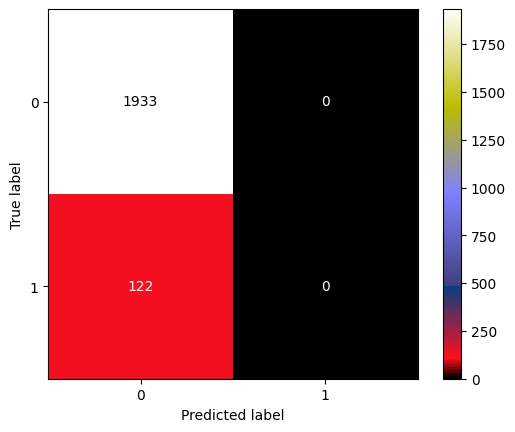

In [22]:
from sklearn.metrics import ConfusionMatrixDisplay
clf = SVC(gamma='auto')
dataset = datasets[2]
clf.fit(dataset['x_train'], dataset['y_train'])
ConfusionMatrixDisplay.from_estimator(clf, dataset['x_test'], dataset['y_test'], cmap='gist_stern');

In [23]:
nodes_2007[nodes_2007['source'] == 'train']['y_true'].value_counts()

y_true
0    3776
1     222
Name: count, dtype: int64

In [24]:
df_results = pd.DataFrame(results)
df_results

,model,dataset,AUC,accuracy,precision,recall,f1_score
0,SVM,direct_features_2007,0.510323,0.909489,0.891245,0.909489,0.900042
1,SVM,link_based_2007,0.546522,0.464720,0.899778,0.464720,0.585464
2,SVM,link_based_transformed_2007,0.627215,0.753771,0.909452,0.753771,0.815324
3,SVM,content_based_2007,0.658699,0.834189,0.916432,0.834189,0.868411
4,Random Forest,direct_features_2007,0.569085,0.796107,0.899705,0.796107,0.840723
5,Random Forest,link_based_2007,0.616098,0.826764,0.907663,0.826764,0.861381
6,Random Forest,link_based_transformed_2007,0.630601,0.810706,0.909854,0.810706,0.851993
7,Random Forest,content_based_2007,0.735840,0.877823,0.930071,0.877823,0.898937
8,Bayes,direct_features_2007,0.500000,0.059367,0.003524,0.059367,0.006654
9,Bayes,link_based_2007,0.529045,0.915815,0.896899,0.915815,0.905765


In [25]:
df_results['dataset'] = pd.Categorical(df_results['dataset'], ['direct_features_2007', 'link_based_2007', 'link_based_transformed_2007', 'content_based_2007'])

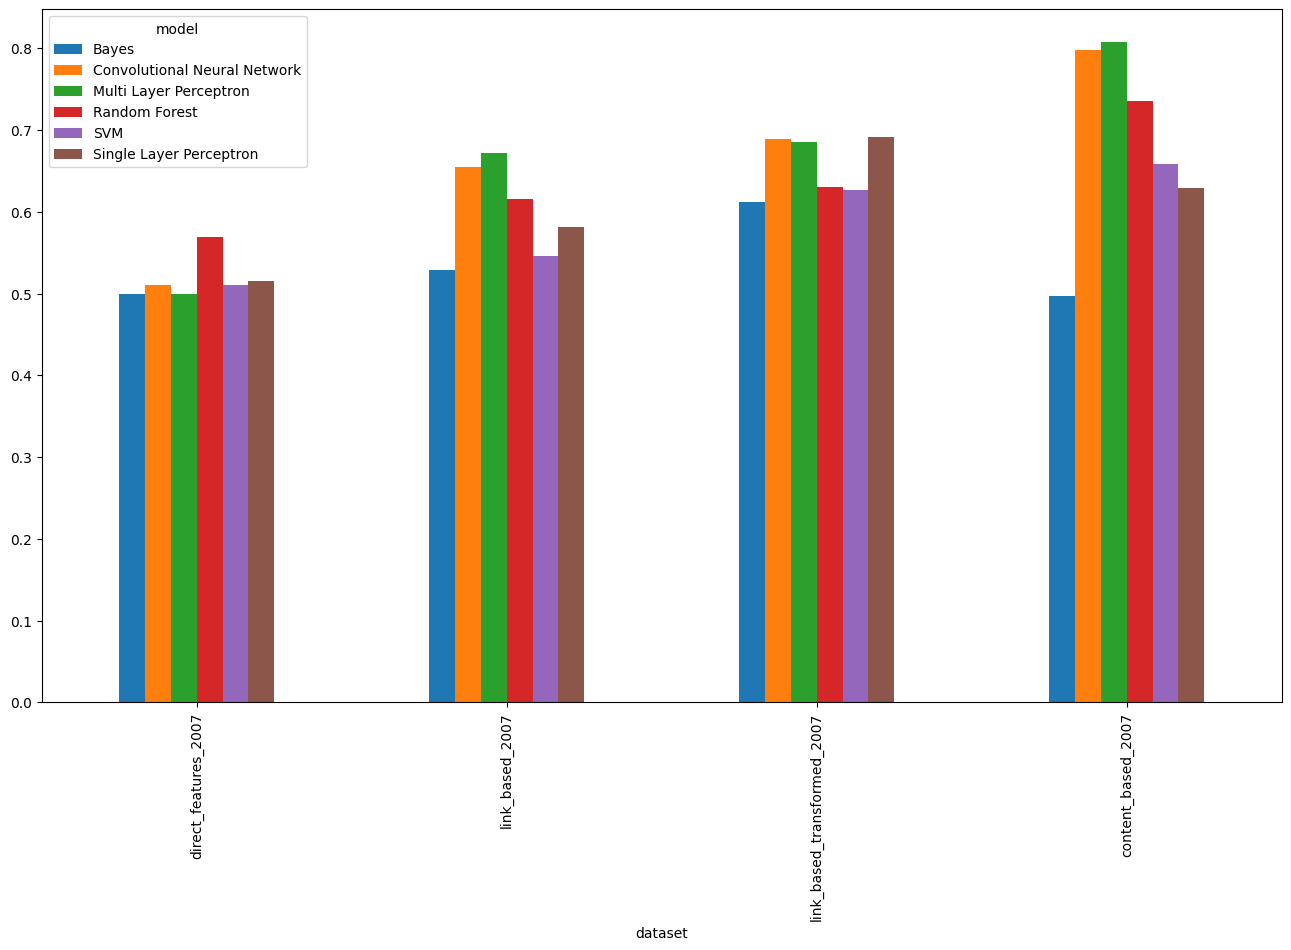

In [26]:
df_results[['dataset', 'model', 'AUC']].pivot_table(values='AUC', index='dataset', columns="model").plot(kind='bar', figsize=(16,9));

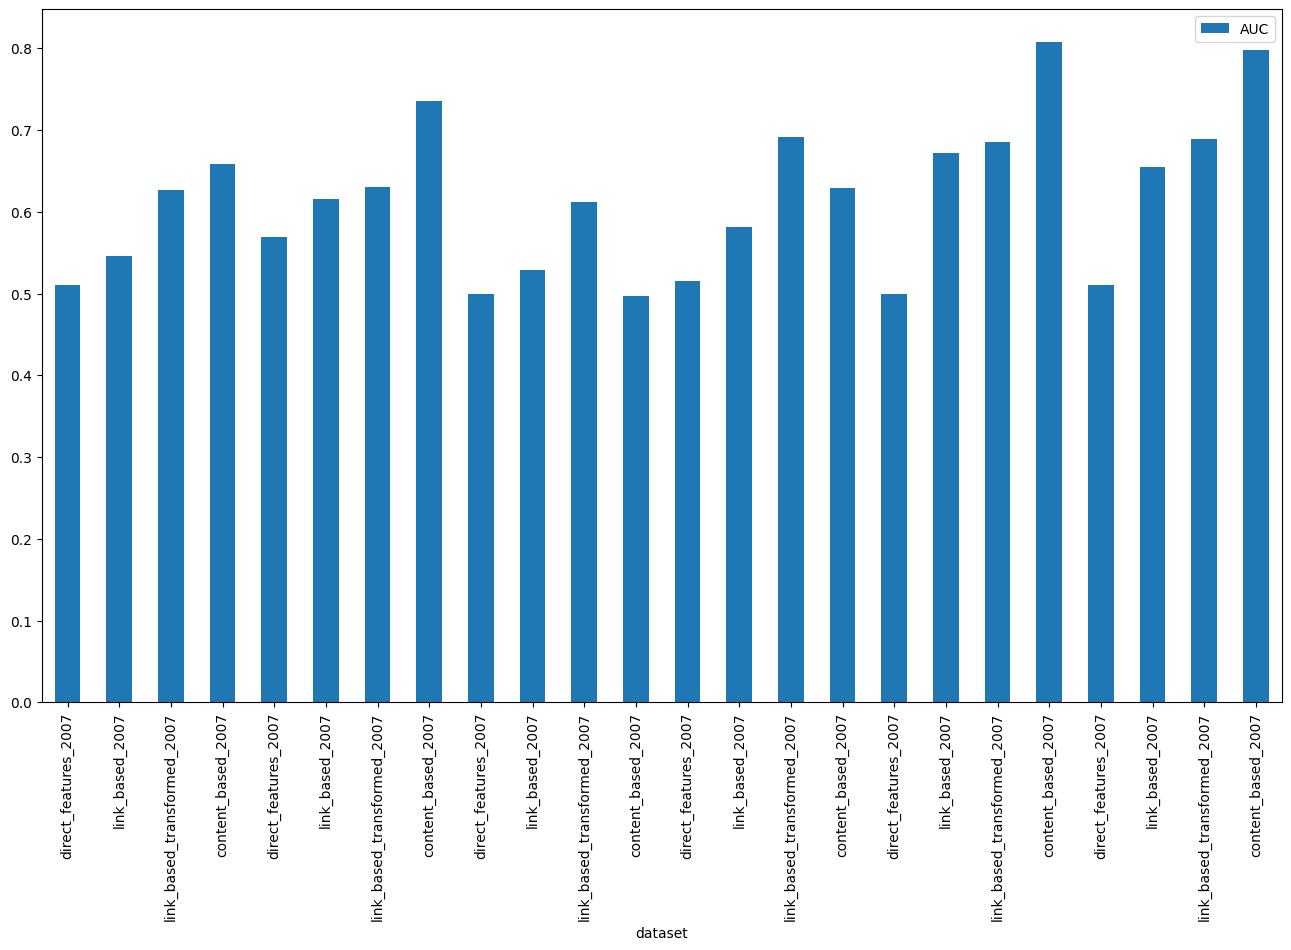

In [27]:
df_results.plot(kind='bar', x='dataset', y='AUC', figsize=(16, 9));

In [28]:
G = nx.DiGraph()

with gzip.open('data/2007/uk-2007-05.hostgraph_weighted.graph-txt.gz', 'rb') as f:
    next(f)
    i = 0
    for raw_row in f:
        row = raw_row.decode().strip().split(' ')
        if row[0] == '' or (i not in nodes_2007.index):
            i += 1
            continue
        row_add = []
        for value in row:
            split_value = value.split(':')
            if int(split_value[0]) not in nodes_2007.index:
                continue
            row_add.append((i, int(split_value[0]), int(split_value[1])))
        i += 1
        G.add_weighted_edges_from(row_add)

attributes_dict = nodes_2007[['hostname', 'y_true']].to_dict(orient='index')
nx.set_node_attributes(G, attributes_dict)

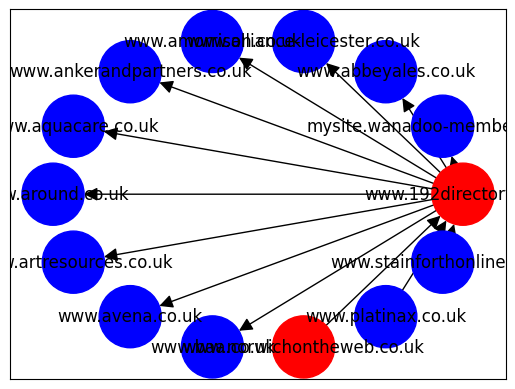

In [29]:
import matplotlib.pyplot as plt
node = 8270
subgraph = nx.DiGraph()
subgraph.add_node(node, **G.nodes[node])
i = 0
for neighbor in G.successors(node):
    subgraph.add_node(neighbor, **G.nodes[neighbor])
    subgraph.add_edge(node, neighbor)
    i += 1
    if i == 10:
        break
i = 0
for neighbor in G.predecessors(node):
    subgraph.add_node(neighbor, **G.nodes[neighbor])
    subgraph.add_edge(neighbor, node)
    i += 1
    if i == 10:
        break
labels = {n: f"{G.nodes[n]['hostname']}" for n in subgraph.nodes}
color_map = ['red' if G.nodes[n]['y_true'] == 1 else 'blue' for n in subgraph.nodes]
pos = nx.circular_layout(subgraph)
nx.draw_networkx(subgraph, pos, with_labels=True, labels=labels, node_color=color_map, node_size=2000, arrowstyle='-|>', arrowsize=20);